In [134]:
#noexport
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [135]:
#noexport
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, IntSlider


In [136]:
import os

import torch
from fastai.vision.all import *
from fastai.distributed import *
import fastai
import sklearn.metrics as skm
import pandas as pd
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 170)
#pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2

pd.set_option('display.max_columns', None)

from TMA_tools import Spot, TMA, WSI


In [137]:

#%run TMA_tools.ipynb

In [138]:
_p_csv_1 = Path('dataset_TCGA_MSI-H_level_0_no_overlap_labeled_tissue.csv')
_p_csv_0 = Path('dataset_TCGA_MSS_level_0_no_overlap_labeled_tissue.csv')
_p_csv = Path('dataset_level_all_March21_no_overlap_labeled_tissue.csv')
p_csv = Path('dataset_level_all_no_overlap_labeled_tissue.csv')

epicolon = False
from ast import literal_eval
#d = pd.read_csv(p_csv, dtype= { 'spot_ID':str }, converters={
    #'tile': literal_eval, 'tile_rot_augmentation': literal_eval})
#d = pd.concat([load_dataset(0), load_dataset(1), load_dataset(2), load_dataset(3), load_dataset(4)])
#d = pd.DataFrame(data=d.values,columns=d.columns)


In [139]:
import datatable as dt
d = dt.fread(_p_csv_0).to_pandas()
print(d.shape)
_d = dt.fread(_p_csv_1).to_pandas()
d = pd.concat([d,_d])
d.shape #n tiles extracted from TCGA 

(1559775, 8)


(2064414, 8)

In [140]:
#correct labels in two patients with mixed labels in source data (verified with AP)
if epicolon:
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI
d.patient_ID.nunique(), d.loc[d.label == 1].patient_ID.nunique() 
d[4582:4584]

,C0,tile,path,svs_fn,patient_ID,label,clas_idx,probs
4582,473,"[10575, 5391, (300, 300), 0]",TCGA/SVS,TCGA-AA-3818-01A-01-BS1.f5edf326-deec-4439-9f2e-27b47b6061af,TCGA-AA-3818,2,7,"[0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.99, 0.0]"
4583,474,"[10774, 5391, (300, 300), 0]",TCGA/SVS,TCGA-AA-3818-01A-01-BS1.f5edf326-deec-4439-9f2e-27b47b6061af,TCGA-AA-3818,2,7,"[0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.96, 0.01]"


In [141]:
def eval_fields(df):
    df.tile = df.tile.apply(lambda x: eval(str(x)))
    
    #df.tile_rot_augmentation = df.tile_rot_augmentation.apply(lambda x: eval(str(x)))
    return df
df_split = np.array_split(d, 32)

res = parallel(partial(eval_fields), df_split)
d = pd.concat([*res])



In [142]:

d['zoom'] = d.tile.apply(lambda o: o[3])
d.zoom.value_counts()

0    2064414
Name: zoom, dtype: int64

In [143]:

d.patient_ID = d.patient_ID.astype(str)



In [144]:

d[d.patient_ID.str.contains('.0', regex = False)].patient_ID.nunique()

0

In [145]:
d['patient_ID'] = d.patient_ID.str.replace('.0','', regex=False)


In [146]:
#correct labels in two patients with mixed labels in source data (verified with AP)
if epicolon:
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI
    d.patient_ID.nunique(), d.loc[d.label == 1].patient_ID.nunique()  

In [147]:
#df with a tile covering the entire area of each spot
ds_spot_4 = d.loc[d.zoom == 4] 

In [148]:
cls = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
d['clas_idx_notdecoded'] = d.clas_idx
d.clas_idx = d.clas_idx.apply(lambda o: cls[o])

In [149]:

d.clas_idx.unique()

array(['STR', 'DEB', 'TUM', 'ADI', 'NOR', 'LYM', 'BAC', 'MUS', 'MUC'],
      dtype=object)

In [150]:
#remove tissue background/adipose
#d = d.loc[~d.clas_idx.isin(['ADI','BAC','', 'MUC'])]
d = d.loc[d.clas_idx.isin(['TUM','STR', 'LYM', 'MUC'])] #TODO: Try adding MUC #No improvments
d = d.loc[d.clas_idx.isin(['TUM'])] 

In [151]:
d.reset_index(inplace = True)

In [152]:
d.label.describe()

count    970874.000000
mean          1.778226
std           0.415440
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: label, dtype: float64

d['zoom'] = d.tile.apply(lambda x: x[3])
d.zoom

In [153]:
if epicolon:
    patient_label = d.groupby(['patient_ID','label']).groups.keys()
    patient_label = pd.DataFrame({'patient_ID' : np.array([list(i) for i in list(patient_label)])[:,0], 'label' : np.array([list(i) for i in list(patient_label)])[:,1]})
    patient_label['HGUA'] = patient_label.patient_ID.apply(lambda x: 1 if ('B' in x or '-' in x or x.startswith('12')) else 0)
    patient_label.groupby(['label', 'HGUA']).describe()

In [154]:
from sklearn.utils.class_weight import compute_class_weight

In [155]:
if epicolon:
    patient_label['bias_label'] = pd.to_numeric(patient_label.label, downcast='integer')*10 + patient_label.HGUA.apply(int)
    patient_label = patient_label[patient_label.bias_label < 31]
    patient_label['bias_label'].value_counts()

In [156]:
weights = None
if epicolon:
    classes = patient_label['bias_label'].unique()
    weights = compute_class_weight('balanced', classes=classes, y=patient_label['bias_label'])
    print(classes, weights)
    weights_df = pd.DataFrame({'bias_label': classes, 'weights': weights})

else:
    classes = d.label.unique()
    weights = compute_class_weight('balanced', classes=classes, y=d.label)
    print(classes, weights)
    weights_df = pd.DataFrame({'label': classes, 'weights': weights})



[2 1] [0.64248722 2.25454334]


In [157]:
if epicolon:
    patient_label['valid'] = 0
    patient_label.loc[patient_label.index.isin(patient_label.sample(frac=0.2, random_state=1).index), 'valid'] = 1
    patient_label.groupby('bias_label').describe()
    #check inmmutable patient valid partition 
    patient_df = pd.read_csv('valid_partition_TUM_only.csv')
    valid_set_csv = set(patient_df[patient_df.valid == 1].patient_ID)
    valid_set = set(patient_label[patient_label.valid == 1].patient_ID)
    assert len(valid_set - valid_set_csv.intersection(valid_set)) == 0

# Filter dataset 

In [158]:
d.drop(columns = ['index', 'C0'], inplace = True)

In [159]:
d.columns

Index(['tile', 'path', 'svs_fn', 'patient_ID', 'label', 'clas_idx', 'probs',
       'zoom', 'clas_idx_notdecoded'],
      dtype='object')

In [160]:
f = None
if epicolon:
    f = d.merge(patient_label[['patient_ID','bias_label','valid']], on = 'patient_ID')
    f = f.merge(weights_df, on = 'bias_label')
else: 
    f = d.merge(weights_df, on = 'label')
    


In [161]:

f['valid'] = 0
patient_keys_MSS, patient_keys_MSI = f.loc[f.label == 2].patient_ID.unique(), f.loc[f.label == 1].patient_ID.unique()
print(f'MSS patients = {len(patient_keys_MSS)} ({len(patient_keys_MSS)*100/f.patient_ID.nunique()}%)')
print(f'MSI patients = {len(patient_keys_MSI)} ({len(patient_keys_MSI)*100/f.patient_ID.nunique()}%)')
f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSS).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSI).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
f.valid.value_counts()

MSS patients = 173 (74.56896551724138%)
MSI patients = 59 (25.43103448275862%)


0    766943
1    203931
Name: valid, dtype: int64

In [162]:
patient_keys_MSI

array(['TCGA-D5-6530', 'TCGA-AZ-6598', 'TCGA-AZ-4615', 'TCGA-AA-A01P',
       'TCGA-CM-5861', 'TCGA-D5-6930', 'TCGA-CK-4951', 'TCGA-AA-3966',
       'TCGA-D5-6540', 'TCGA-A6-5661', 'TCGA-F4-6703', 'TCGA-AG-A02N',
       'TCGA-AA-3713', 'TCGA-CK-5916', 'TCGA-G4-6588', 'TCGA-G4-6320',
       'TCGA-AA-3949', 'TCGA-G4-6628', 'TCGA-AA-3864', 'TCGA-AU-6004',
       'TCGA-D5-6928', 'TCGA-AA-3950', 'TCGA-AA-3947', 'TCGA-AA-3663',
       'TCGA-CM-6171', 'TCGA-AA-3492', 'TCGA-CK-5913', 'TCGA-CM-4746',
       'TCGA-CM-6674', 'TCGA-AA-A01R', 'TCGA-AM-5821', 'TCGA-F4-6570',
       'TCGA-A6-5665', 'TCGA-AD-6964', 'TCGA-EI-6507', 'TCGA-A6-2686',
       'TCGA-G4-6302', 'TCGA-G4-6304', 'TCGA-AA-3877', 'TCGA-EI-6882',
       'TCGA-AY-6197', 'TCGA-CM-4743', 'TCGA-CM-6162', 'TCGA-G4-6309',
       'TCGA-AA-3833', 'TCGA-AD-6889', 'TCGA-AA-3811', 'TCGA-G4-6586',
       'TCGA-AD-5900', 'TCGA-F4-6856', 'TCGA-CK-6747', 'TCGA-AA-3715',
       'TCGA-D5-6927', 'TCGA-AA-3821', 'TCGA-AA-3845', 'TCGA-DC-6154',
      

In [163]:
assert len(set(f[f.valid == 0].patient_ID.unique()) & set(f[f.valid == 1].patient_ID.unique()) ) == 0


In [164]:
f.groupby(['label', 'valid']).describe()

zoom                                    clas_idx_notdecoded  \
                count mean  std  min  25%  50%  75%  max               count   
label valid                                                                    
1     0      186750.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            186750.0   
      1       28565.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0             28565.0   
2     0      580193.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            580193.0   
      1      175366.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            175366.0   

                                                 weights            \
            mean  std  min  25%  50%  75%  max     count      mean   
label valid                                                          
1     0      8.0  0.0  8.0  8.0  8.0  8.0  8.0  186750.0  2.254543   
      1      8.0  0.0  8.0  8.0  8.0  8.0  8.0   28565.0  2.254543   
2     0      8.0  0.0  8.0  8.0  8.0  8.0  8.0  580193.0  0.642487   
      1      8.0  0.0  8.0  8.0  8.0  8.0  8.0  175366.0  0.642487   

                                                                             
                      std       min       25%       50%       75%       max  
label valid                                                                  
1     0      4.440904e-16  2.254543  2.254543  2.254543  2.254543  2.254543  
      1      4.440970e-16  2.254543  2.254543  2.254543  2.254543  2.254543  
2     0      4.440896e-16  0.642487  0.642487  0.642487  0.642487  0.642487  
      1      3.330679e-16  0.642487  0.642487  0.642487  0.642487  0.642487

In [165]:
if epicolon:
    f.groupby(['bias_label','valid']).describe()

In [166]:
#noexport
f.zoom.describe()

count    970874.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: zoom, dtype: float64

In [167]:
zoom_filter = None
if zoom_filter: 
    f = f.loc[d.zoom == zoom_filter]
else:
    f = f
print(f'{f.patient_ID.nunique()} patients ( {f.loc[(f.valid == 1)].patient_ID.nunique()} validation )')  
print(f'MSI {f.loc[f.label == 1].patient_ID.nunique()} patients ( {f.loc[(f.label == 1) & (f.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  

232 patients ( 47 validation )
MSI 59 patients ( 12 validation )


In [168]:
tissue_filter  = None
#Filter not enough labeled tum tiles
if tissue_filter:
    n_tiles = 20 #required number of representative tiles for each patient
    selected_tissues = ['TUM','STR','LYM'] #selected tissue types potentially meaningful for MSI
    assert type(eval(f.probs.values[0])[8]) == float #check tissue probabilites have been loaded and are retrievable in pandas
    print(f'{f.loc[f.clas_idx.isna()].patient_ID.nunique()} patients are not tissue labeled because of scarce tissue')
    
    def g(x):
        result = True
        r = x.clas_idx.value_counts()
        count = 0
        for ti in selected_tissues: 
            if ti in r.index: 
                count += r[ti]
        
        return count 

    valid_tiles = pd.DataFrame(f.groupby(['patient_ID']).apply(lambda x: g(x)), columns = ['counts'])
    not_enough_labeled_tum_tiles = valid_tiles.loc[valid_tiles.counts < n_tiles]
    print(not_enough_labeled_tum_tiles.index)
    not_enough_labeled_tum_tiles.plot.hist()
    
    f = f.loc[f.patient_ID.isin(not_enough_labeled_tum_tiles.index) == False]
    f = f.loc[f.clas_idx.isna() == False]
    
    print(f'{f.patient_ID.nunique()} patients ( {f.loc[(f.valid == 1)].patient_ID.nunique()} validation )')  
    print(f'MSI {f.loc[f.label == 1].patient_ID.nunique()} patients ( {f.loc[(f.label == 1) & (f.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  

### Assert training and validation partition avoids patient overlap

In [169]:
d_sub = f
d_sub.columns

Index(['tile', 'path', 'svs_fn', 'patient_ID', 'label', 'clas_idx', 'probs',
       'zoom', 'clas_idx_notdecoded', 'weights', 'valid'],
      dtype='object')

In [170]:
print(f'{d_sub.patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.valid == 1)].patient_ID.nunique()} validation )')  
print(f'MSI {d_sub.loc[d_sub.label == 1].patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.label == 1) & (d_sub.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  
    

d_sub = d_sub.sample(frac=1).reset_index(drop=True)
splitter = ColSplitter('valid')
error_label = set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique()))
print(f'mixed labels:  {error_label}')
assert(set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique())) == set())
assert(np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals=1
           ) == np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals = 1))
example = d_sub.iloc[splitter(d_sub)[1]].iloc[72]
#print(example)

    

232 patients ( 47 validation )
MSI 59 patients ( 12 validation )
mixed labels:  set()


In [171]:
def get_x(r):
    img = None
    if epicolon:
        img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
    else:
        img = WSI.get_tile(*(r.tile), path=r.path, svs_fn = r.svs_fn)
    
    return img
    

def label_func(r): 
    s = None
    try:
        s = 'MSI' if r.label == 1 else 'MSS'
    except :
        print(r)
   
    return s 

def label_bias_func(r): 
    s = None
    try:
        if epicolon:
            s = 'HGUA' if 'B' in r.spot_ID else 'Other'
        else: 
            s = 'TCGA' #fix in table
    except :
        print(f)
    
    return s 

def label_double_func(r):
    
    return ([label_func(r), label_bias_func(r)])



In [172]:

pd.options.mode.chained_assignment = None  # default='warn'
tissue = 'TUM'
cls_tissue = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']




In [173]:
test_example = True

['MSS', 'TCGA']
tile                                                  [44887, 14344, (300, 300), 0]
path                                                                       TCGA/SVS
svs_fn                 TCGA-AZ-6603-01A-01-BS1.6e9202f9-7986-41c0-8bb0-0d81e97ebd60
patient_ID                                                             TCGA-AZ-6603
label                                                                             2
clas_idx                                                                        TUM
probs                                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99]
zoom                                                                              0
clas_idx_notdecoded                                                               8
weights                                                                    0.642487
valid                                                                             1
Name: 22230, dtype: object


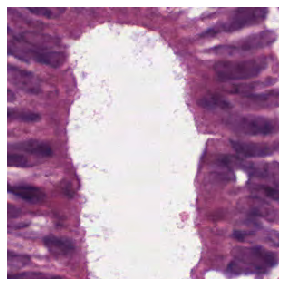

In [174]:
#noexport
if test_example:
    example = d_sub.iloc[splitter(d_sub)[1]].iloc[4582]
    print(label_double_func(example))
    print(example)
    pati = get_x(example)
    show_image(pati)
        

In [178]:

tissue_stats =  ([0.6365042 , 0.4866035 , 0.66030514],[0.2311546 , 0.27366328, 0.19013868]) #EPICOLON TUM+STR+LYM selected
#tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
#tissue_stats = ([0.6698, 0.5181, 0.6594], [0.2080, 0.2573, 0.1874]) #TCGA svs  
#tissue_stats = ([0.6865583 , 0.5289199 , 0.66556716], [0.20485608, 0.2561432 , 0.18819469]) #TCGA svs TUM+STR+LYM selected
tissue_stats

([0.6365042, 0.4866035, 0.66030514], [0.2311546, 0.27366328, 0.19013868])

In [179]:
_d_sub = d_sub#.sample(frac=.01)
_d_sub.shape

(970874, 11)

In [180]:
#def img2tensor(im: Image.Image): return TensorImage(array(im)[None])
def img2tensor(img: np.ndarray): 
    t = torch.Tensor(np.array(img))
    t = t.permute(2,0,1).float()/255.0
    return TensorImage(t)
tfms = [[get_x, img2tensor],
       [label_func, Categorize(vocab = ['MSS', 'MSI'], sort = False)],
       [label_bias_func, Categorize(vocab = ['Other', 'HGUA', 'TCGA'], sort = False)]]
train_ds = Datasets(_d_sub[_d_sub.valid == 0],tfms,n_inp=1)
valid_ds = Datasets(_d_sub[_d_sub.valid == 1],tfms,n_inp=1)

In [181]:
xd,yd, yd1 = decode_at(train_ds,3)
xd.shape,yd, yd1

(torch.Size([3, 300, 300]), 'MSS', 'TCGA')

In [182]:
x,y,y1 = train_ds[3]
x,y,y1

(TensorImage([[[0.7882, 0.5843, 0.4980,  ..., 0.5961, 0.5843, 0.7216],
          [0.9098, 0.7529, 0.5882,  ..., 0.5412, 0.6196, 0.6549],
          [0.9373, 0.8471, 0.7412,  ..., 0.5451, 0.5961, 0.5922],
          ...,
          [0.6157, 0.6549, 0.6706,  ..., 0.4000, 0.4039, 0.4039],
          [0.6078, 0.6314, 0.6706,  ..., 0.4039, 0.4157, 0.3961],
          [0.5804, 0.6078, 0.6627,  ..., 0.4314, 0.4510, 0.4667]],
 
         [[0.6627, 0.4118, 0.3255,  ..., 0.3922, 0.4235, 0.5843],
          [0.8431, 0.6353, 0.4196,  ..., 0.3608, 0.4118, 0.5333],
          [0.8941, 0.7608, 0.6157,  ..., 0.3686, 0.4196, 0.4549],
          ...,
          [0.4588, 0.4863, 0.4980,  ..., 0.2275, 0.2431, 0.2157],
          [0.4706, 0.4980, 0.5373,  ..., 0.2275, 0.2431, 0.2353],
          [0.4353, 0.4745, 0.5373,  ..., 0.2471, 0.2588, 0.2784]],
 
         [[0.7922, 0.6118, 0.5451,  ..., 0.5961, 0.6392, 0.7176],
          [0.8941, 0.7529, 0.6000,  ..., 0.5647, 0.6235, 0.6784],
          [0.9373, 0.8471, 0.7373, 

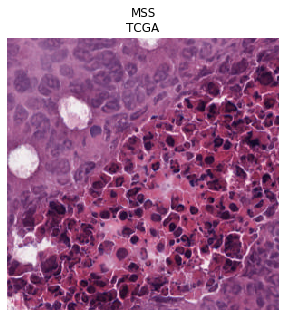

In [183]:
show_at(train_ds, 5004, figsize=(5,5))

In [184]:
bs = 8* 64 * torch.cuda.device_count()
print(f'batch size= {bs}')
#aug = aug_transforms(mult=2, flip_vert=True, max_rotate=90., min_zoom=0.5, max_zoom=5, size = 224)
aug = aug_transforms(mult=1, flip_vert=True, max_rotate=90., min_zoom=1, max_zoom=1, size = 224,
                 max_lighting=0,p_lighting=0, )
wgts = _d_sub[_d_sub.valid == 0].weights.values

batch size= 512


In [185]:
calculate_stats = False
if calculate_stats:
    train_dl = WeightedDL(train_ds,shuffle=True,bs=5000, device=default_device(),
                     wgts=wgts,)
    valid_dl = WeightedDL(valid_ds,wgts=None,bs=2500)
    dls = DataLoaders(train_dl, valid_dl, device=default_device(), )
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)

    

In [186]:
train_dl = WeightedDL(train_ds,shuffle=True,bs=bs, 
                      after_batch=[Normalize.from_stats(*tissue_stats), *aug,],
                     device=default_device(),
                     wgts=wgts,)
valid_dl = TfmdDL(valid_ds,bs=bs,after_batch=[Normalize.from_stats(*tissue_stats)])

In [187]:
dls = DataLoaders(train_dl, valid_dl, device=default_device(), )

In [188]:
#noexport
dls.train.dataset

(#766943) [(TensorImage([[[0.9255, 0.9216, 0.9216,  ..., 0.8706, 0.8314, 0.7059],
         [0.9255, 0.9216, 0.9216,  ..., 0.8941, 0.8588, 0.7647],
         [0.9294, 0.9294, 0.9255,  ..., 0.8314, 0.7961, 0.7686],
         ...,
         [0.4706, 0.4510, 0.4275,  ..., 0.5529, 0.6078, 0.7137],
         [0.5137, 0.4431, 0.3765,  ..., 0.6157, 0.6784, 0.7569],
         [0.5294, 0.4196, 0.3333,  ..., 0.6706, 0.7490, 0.8078]],

        [[0.8706, 0.8667, 0.8588,  ..., 0.7137, 0.6627, 0.5412],
         [0.8784, 0.8706, 0.8667,  ..., 0.7333, 0.7176, 0.6471],
         [0.8824, 0.8784, 0.8706,  ..., 0.6824, 0.6745, 0.6784],
         ...,
         [0.2118, 0.1961, 0.1804,  ..., 0.2431, 0.3098, 0.4549],
         [0.2235, 0.1961, 0.1765,  ..., 0.2863, 0.3569, 0.4745],
         [0.2157, 0.1725, 0.1490,  ..., 0.3294, 0.4118, 0.4863]],

        [[0.8980, 0.8980, 0.9020,  ..., 0.8039, 0.7843, 0.7137],
         [0.9020, 0.9020, 0.9059,  ..., 0.8039, 0.8039, 0.7686],
         [0.9059, 0.9059, 0.9059,  ..., 0

In [189]:
#noexport
dls.train.one_batch()

(TensorImage([[[[ 2.1583e-01, -5.3903e-02, -2.6162e-01,  ...,  1.3011e+00,
             1.3011e+00,  1.2943e+00],
           [ 9.4767e-02, -9.5741e-02, -2.0919e-01,  ...,  1.3011e+00,
             1.3058e+00,  1.3215e+00],
           [ 1.3205e-01, -3.5738e-02, -1.1226e-01,  ...,  1.3234e+00,
             1.3404e+00,  1.3514e+00],
           ...,
           [-1.1213e-01, -2.2313e-01, -2.6780e-01,  ...,  3.6100e-01,
             4.3134e-01,  6.3470e-01],
           [-1.0395e-01, -2.5512e-01, -3.8497e-01,  ...,  2.1591e-01,
            -2.4844e-03, -2.2430e-01],
           [-4.3161e-02, -1.2504e-01, -1.6043e-01,  ..., -6.4954e-01,
            -7.7868e-01, -9.4712e-01]],
 
          [[ 1.1760e-01, -2.8116e-01, -5.3044e-01,  ...,  1.6181e+00,
             1.6176e+00,  1.6054e+00],
           [-1.9867e-02, -3.2007e-01, -4.5846e-01,  ...,  1.6181e+00,
             1.6161e+00,  1.5955e+00],
           [ 3.3086e-02, -2.6899e-01, -4.0975e-01,  ...,  1.6325e+00,
             1.6190e+00,  1.6189e+

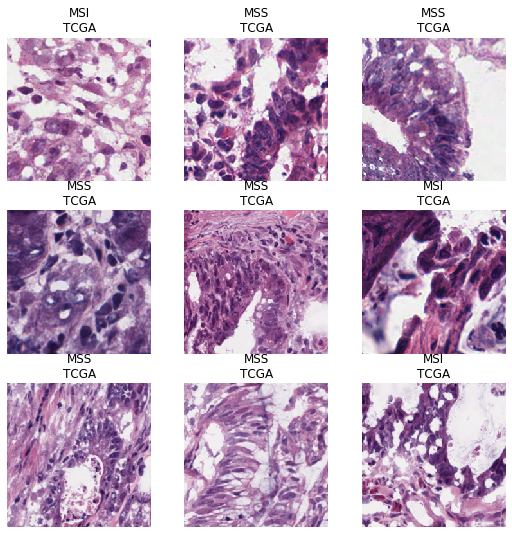

In [190]:
#noexport
dls.show_batch()

In [191]:
#noexport
dls.vocab

(#2) [['MSS', 'MSI'],['Other', 'HGUA', 'TCGA']]

In [192]:
#noexport
print (dls[0].tfms)
print (dls[0].after_batch)
bx=dls.one_batch()[0]
print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
aug

[Pipeline: get_x -> img2tensor, Pipeline: label_func -> Categorize -- {'vocab': ['MSS', 'MSI'], 'sort': False, 'add_na': False}, Pipeline: label_bias_func -> Categorize -- {'vocab': ['Other', 'HGUA', 'TCGA'], 'sort': False, 'add_na': False}]
Pipeline: Dihedral -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.6365]],

         [[0.4866]],

         [[0.6603]]]], device='cuda:0'), 'std': tensor([[[[0.2312]],

         [[0.2737]],

         [[0.1901]]]], device='cuda:0'), 'axes': (0, 2, 3)}
TensorImage(-3.3965, device='cuda:0') TensorImage(1.8760, device='cuda:0') TensorImage([0.1845, 0.1521, 0.0389], device='cuda:0') TensorImage([0.8813, 0.9334, 0.9695], device='cuda:0')


[Dihedral -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ]

# Model

In [193]:
print(Path('models').ls())

[Path('models/segment_tissue_0.4554598927497864_f_acc_0.8807398080825806.pth'), Path('models/segment_tissue_0.3260129690170288_f_acc_0.900049090385437.pth'), Path('models/segment_tissue_presizing0.4628714621067047_f_acc_0.8756903409957886.pth'), Path('models/segment_tissue_presizing0.34281474351882935_f_acc_0.9168598055839539.pth'), Path('models/segment_tissue_9_class_2.2231385707855225_f_acc_nan.pth'), Path('models/segment_tissue_9_class.pth'), Path('models/pretrained_tissue_aug_0.999517653648182.pth'), Path('models/pretrained_tissue_aug_BAC_epicolon0.9993681800971788.pth'), Path('models/MSI_classifier_epicolon_0.8591032422872864.pth'), Path('models/MSI_classifier_epicolon_level_3_0.8562268910196152.pth'), Path('models/MSI_classifier_epicolon_level_2_0.8516107310959105.pth'), Path('models/MSI_classifier_epicolon_level_1_0.8722223505233963.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8644301847354364.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8745365282255746.pth'),

In [194]:
b = dls[1].one_batch()

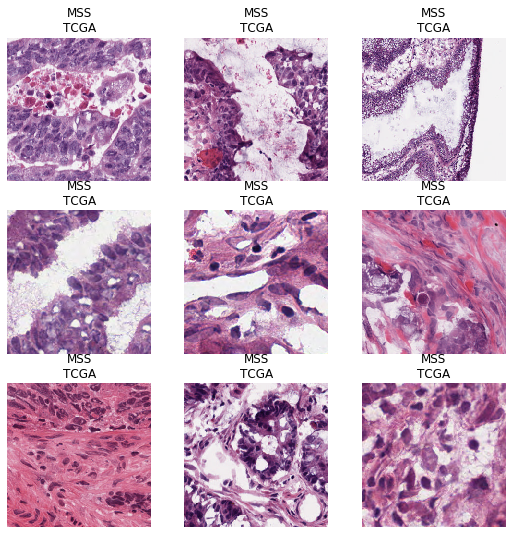

In [195]:
dls.show_batch(b)

In [196]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[error_rate,RocAuc()],normalize=False, n_out=9,
                                  path=Path("."), pretrained=False, loss_func=CrossEntropyLossFlat())


tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'

learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model

if test_example: #visually check tissue type classification in loaded dataset (TODO: check odd behaviour as all the samples were previously selected as TUM)
    #x = torch.randn(2,3,300,300)
    bx = b[0]
    _preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=-1)(_preds), dim = -1)
    #print(preds)
    classes = [cls_tissue[i] for i in preds]
    print(classes[:9])
    


['TUM', 'TUM', 'BAC', 'DEB', 'MUS', 'STR', 'MUS', 'NOR', 'NOR']


In [197]:
preds

TensorImage([8, 8, 1, 2, 5, 7, 5, 6, 6, 3, 6, 7, 6, 5, 8, 5, 4, 3, 4, 3, 8, 3, 8, 3,
        2, 3, 2, 2, 8, 3, 6, 4, 8, 4, 0, 6, 8, 8, 4, 3, 3, 8, 8, 3, 7, 7, 1, 4,
        6, 7, 8, 4, 5, 7, 8, 4, 0, 0, 6, 2, 2, 7, 6, 3, 3, 8, 8, 1, 6, 7, 2, 8,
        8, 5, 6, 8, 5, 8, 3, 4, 6, 4, 8, 5, 6, 5, 6, 0, 2, 3, 8, 7, 6, 2, 5, 1,
        8, 6, 8, 8, 8, 4, 4, 2, 3, 4, 2, 5, 6, 5, 2, 0, 2, 2, 8, 3, 5, 8, 6, 0,
        7, 3, 4, 5, 2, 6, 2, 0, 3, 6, 7, 7, 8, 2, 6, 2, 5, 8, 8, 6, 2, 8, 8, 2,
        5, 6, 0, 0, 0, 8, 6, 5, 5, 4, 0, 6, 4, 7, 7, 5, 0, 5, 8, 2, 8, 8, 7, 4,
        2, 6, 2, 2, 6, 0, 5, 8, 3, 6, 1, 2, 1, 4, 2, 2, 0, 6, 6, 2, 8, 0, 2, 8,
        2, 0, 7, 8, 5, 0, 2, 2, 2, 6, 2, 7, 7, 5, 8, 2, 8, 0, 2, 8, 8, 5, 4, 2,
        7, 5, 8, 8, 8, 8, 2, 2, 5, 8, 1, 8, 4, 5, 8, 4, 8, 8, 8, 5, 2, 0, 5, 4,
        6, 7, 7, 5, 5, 6, 6, 2, 4, 4, 7, 8, 8, 6, 6, 8, 8, 2, 8, 8, 0, 3, 8, 7,
        6, 8, 7, 8, 2, 6, 5, 5, 2, 5, 6, 7, 6, 2, 2, 6, 6, 3, 5, 6, 2, 8, 2, 6,
        6, 8, 6, 6, 8, 4, 7, 2, 8, 

In [198]:
class DropBiasInXY(Callback):
    run_train = False
    def after_pred(self):
        if isinstance(self.learn.pred,tuple) and len(self.learn.pred)>1:
            self.learn.pred = self.learn.pred[0] 
        if isinstance(self.learn.yb,tuple) and len(self.learn.yb)>1:
            self.learn.yb   = (self.learn.yb[0],)
            

In [62]:
learn_pretrained.metrics = []
res = learn_pretrained.get_preds(cbs=[DropBiasInXY()])

In [63]:
res[0][:10]

TensorImage([[6.7592e-07, 9.1999e-07, 1.5717e-04, 4.8236e-07, 1.4604e-04, 2.3529e-08,
         2.3849e-01, 9.2455e-06, 7.6120e-01],
        [2.8342e-07, 7.9281e-07, 2.2788e-02, 2.9759e-06, 2.6906e-05, 1.4756e-05,
         1.2742e-01, 3.9491e-05, 8.4971e-01],
        [6.8297e-04, 2.7348e-04, 4.8437e-02, 1.1601e-03, 8.3363e-03, 5.9907e-04,
         4.3327e-01, 2.2327e-03, 5.0501e-01],
        [6.2681e-03, 3.2364e-03, 1.3157e-01, 5.9391e-05, 9.0589e-02, 8.2119e-05,
         3.4950e-03, 3.4397e-04, 7.6436e-01],
        [2.3601e-04, 4.1127e-05, 4.1115e-02, 2.2362e-04, 2.1029e-02, 7.2031e-05,
         2.0868e-01, 9.4334e-03, 7.1917e-01],
        [8.9132e-02, 2.3014e-03, 1.4033e-02, 8.0232e-06, 9.1745e-02, 1.2191e-03,
         7.7208e-03, 6.8151e-04, 7.9316e-01],
        [1.4128e-05, 2.1377e-06, 1.7409e-02, 4.5497e-08, 1.7492e-04, 1.9734e-06,
         4.8148e-05, 1.9504e-04, 9.8215e-01],
        [1.8866e-05, 6.8767e-06, 1.6197e-02, 1.6708e-07, 1.4217e-02, 3.5148e-06,
         8.2332e-04, 3.29

In [199]:
@patch
def __accum_values(self:AccumMetric, preds, targs,learn=None):
    "Store targs and preds"
    to_d = learn.to_detach if learn is not None else to_detach
    print(preds,targs)
    preds,targs = to_d(preds),to_d(targs)
    print(preds,targs)
    keep = targs != -100
    preds,targs = preds[keep],targs[keep]
    if preds.numel() == 0: return
    if self.flatten: preds,targs = flatten_check(preds,targs)
    self.preds.append(preds)
    self.targs.append(targs)
    

In [200]:
from fastai.fp16_utils import convert_network
class PutYinX(Callback):
    def __init__(self,m_tissue_classifier): 
        self.tissue_classifier = m_tissue_classifier
        self.tissue_classifier.eval().cuda()
    def before_batch(self):
        #self.learn.xb = self.learn.xb[0],self.learn.xb[1], self.learn.xb[1]
        pass
    def after_pred(self):
        if self.learn.y is None: return
        with torch.no_grad():
            tissue_class = convert_network(self.tissue_classifier,x.dtype)(self.x)
        tissue_class = torch.argmax(nn.Softmax(dim=1)(tissue_class), dim = 1)
        def change(t,cond):
            t[cond]=-100
            return t
        self.learn.yb = apply(partial(change,cond=tissue_class <= 1 ),self.learn.yb)

In [201]:
class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        self.force_msi = False
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0], 
            ).cuda()
        
        self.msi_classifier = nn.Sequential(
            AdaptiveConcatPool2d(1),
            Flatten(full=False), 
            #nn.AdaptiveAvgPool2d(1),
            #nn.Flatten(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias_classifier = nn.Sequential(
            AdaptiveConcatPool2d(1),
            Flatten(full=False), 
            #nn.AdaptiveAvgPool2d(1),
            #nn.Flatten(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
    
    def forward(self, x, _forward=None):
        if _forward is not None: return getattr(self,_forward)(x)
        
        fe = self.feature_extractor(x)
        pred_msi = self.msi_classifier(fe)
        pred_bias = self.bias_classifier(fe)
        
        if self.force_msi or not self.train: return pred_msi
        
        return (pred_msi, pred_bias)


In [202]:
#2 = MSS 1 = MSI ,  0 = Others 1 = HGUA

if epicolon:
    _d_sub.bias_label.value_counts()



In [203]:

# adversial loss for squared correlation 
def correlation_coefficient_loss(y_pred, y_true):
    y = y_true.float()
    x = y_pred.float()
    x = F.softmax(x, dim=-1)
    x = x[:,-1].squeeze()
    
    keep = y != -100
    x,y = x[keep],y[keep]
    #print(x)
    #print(x.shape)
    #print(y.shape)
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    #print(r)
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    return r**2

In [204]:
y_true = torch.tensor([1, 0, -100, 0])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])
print(y_true.shape,y_pred.shape)
correlation_coefficient_loss(y_pred, y_true)

torch.Size([4]) torch.Size([4, 2])


tensor(0.9970)

In [207]:

from torch.autograd import Variable
@patch
def _do_one_batch(self:Learner):
    features = None
    for child in self.model.children():
        for param in child.parameters():
                param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = self.loss_func(self.pred, self.yb[0]); self('after_loss')
    else:
        self.loss = self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 1º training step: MSI-Pred {self.loss}')
    

    for child in self.model.feature_extractor.children():
        for param in child.parameters(): param.requires_grad = False
    #features = self.model.feature_extractor(*self.xb)    
    features = self.model(*self.xb,_forward='feature_extractor')    

    for child in self.model.bias_classifier.children():
        for param in child.parameters(): param.requires_grad = True
    
    #self.pred = self.model.bias_classifier(features);                self('after_pred')
    self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
    cond_target = self.yb[1] #In Hospital target --> 
    cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)
    
    self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
    #self.loss = - correlation_coefficient_loss(self.pred[1], cond_target); self('after_loss')
    
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 2º training step: Bias-Pred {self.loss}')            
     
        
        
    for child in self.model.feature_extractor.children():
        for param in child.parameters():
                param.requires_grad = True
    for child in self.model.bias_classifier.children():
        for param in child.parameters():
                param.requires_grad = False
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #Invert values in Hospital target
    #invert_targ = 1 - self.yb[1] 
    #invert_targ[self.yb[0] == 0] = -100 ##In Hospital target --> ablate MSS samples (coded 0)
    #-((tanh(2x - 1) + 1) / 2) + 1
    #-(1 / (1 + ℯ^(-(4x - 2)))) + 1
    #self.loss = - self.loss_func(self.pred[1], cond_target); self('after_loss')
    
    self.loss = correlation_coefficient_loss(self.pred[1], cond_target); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 3º training step: Bias-Distillator {self.loss}')
    
    
    

In [208]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [209]:
learn_path = Path('models/no_mazenko')
#learn_path = Path('.')

In [210]:
tissue_backbone = True
if tissue_backbone: 
    x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    y = m(x)
    print(y)
    test_eq(y[0].shape, [2, 2])
    learn = Learner(dls, m, path= learn_path, metrics=[error_rate,RocAucBinary()], loss_func = CrossEntropyLossFlat(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [DropBiasInXY(),SaveModelCallback(monitor='roc_auc_score')])
                   #)#,  

else: 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

(tensor([[-0.2139, -1.0150],
        [-0.7517,  0.6851]], device='cuda:0', grad_fn=<MmBackward>), tensor([[ 0.7308,  1.6292],
        [-0.1455, -1.5579]], device='cuda:0', grad_fn=<MmBackward>))


In [211]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : [DropBiasInXY]
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallbac

In [212]:
#learn.to_parallel()

In [213]:
learn.to_fp16()

In [214]:
#learn.dls[0].one_batch()

In [215]:
#learn.validate()



In [216]:
#learn.summary()


In [217]:
train = False
#if train: learn.lr_find()

In [218]:
if train:
    learn.fit_one_cycle(10,1e-5)

In [219]:

if train:
    #learn.fine_tune(20)
    auc_val = learn.final_record[3]
    
    #auc_val = 0.8554
    learn.save(f'MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_{zoom_filter}_TUM_{auc_val}' )
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    #learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902')
    learn.load('MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_None_TUM_0.8848650115631501')

In [220]:
#learn.validate()

In [221]:
#learn.show_results()

In [222]:
#interp = Interpretation.from_learner(learn)

In [223]:
#interp.plot_top_losses(50, figsize=(30,30))

### Label spot wiht sliding tiles

In [ ]:
import matplotlib
#matplotlib.use('Agg') #comment to show images in notebook
import matplotlib.pyplot as plt
cls = ['MSI', 'MSS']


ds_f = _d_sub.loc[(_d_sub.valid == 1)]


#ds_f = _d_sub.loc[(_d_sub.spot_ID == '7123')]
#print(ds_f.valid.mean())

for spot in ds_f.groupby(['spot_coord','tif_fn'] ):
  
    spot_coord, tif_fn = spot[0]
    labels = ['Missing', 'MSI', 'MSS']
    img_label = f'{tif_fn}_{spot_coord}_{spot[1].iloc[0].spot_ID}_Label_{labels[int(spot[1].iloc[0].label)]}.png'
    print(img_label)
    spot[1].reset_index(inplace = True)
    sample_spot = learn.dls.test_dl(spot[1] )
    bx=learn.dls.one_batch()[0] #.mean(dim=[0,2,3])
    #print(f'min, max, mean for RGB colors: {bx.min()},{bx.max()},{bx.mean(dim=[0,2,3])}')
    
    #predict
    imgs, probs, classes, clas_idx = learn.get_preds(dl=sample_spot, with_input=True, with_decoded=True)
    print(f'N of voting tiles: {probs.shape[0]}')
    
    MSI_score = np.mean(probs.cpu().numpy()[:,1])
    print (f'MSI-score= {MSI_score}')
    
    ds_spot_4.loc[(ds_spot_4.tif_fn == tif_fn) & (ds_spot_4.spot_coord ==spot_coord) , 'pred_MSI_score_x20'] = MSI_score
    
    
    #try:
    #create mask
    size_spot = (300,300) #should match tile size for level 4
    # translate pixel level 0 to mask pixel
    spot_4 = ds_spot_4.loc[(ds_spot_4.spot_coord == spot_coord)&(ds_spot_4.tif_fn == tif_fn)]
    pix_up_left_x = spot_4.iloc[0].tile[0]
    pix_up_left_y = spot_4.iloc[0].tile[1]


    size =  (300,300)
    level = spot[1].iloc[0].tile[3]
    zoom_out = 2**4 #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 4 (spot enclosed in 300 x 300 pixel image)
    zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
    tile_mask_side_length = size[0] / zoom_out_tile

    print(f'Each sliding tile will cover in the mask a square of side {tile_mask_side_length} pixels' )
    print(f'Pixel absolute coordinates in original TMA (upper-left and lower-right corners)')
    print(pix_up_left_x, pix_up_left_y)
    print(spot_4.iloc[0].tile[0] + size_spot[0]* 2**4, spot_4.iloc[0].tile[1] + size_spot[0]* 2**4)
    print(f'Upper left square represents the prediction of tile at level 4')

    #---------------------------------------------
    matrix_prob = pd.DataFrame( columns = np.arange(size_spot[0]), index = np.arange(size_spot[0]))
    matrix_prob = matrix_prob.fillna('np.nan(),')
    

    for i, row in spot[1].iterrows():

        x,y= (row.tile[0] - pix_up_left_x) / zoom_out, (row.tile[1] - pix_up_left_y) / zoom_out
        
        zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
        tile_mask_side_length = size[0] / zoom_out_tile
        
        matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length) 
                 ] =  matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length)
                                 ] + str(probs[i][1].cpu().numpy()) + ','




    def f_prob(s):
        result = 0.5 #default (for 0.5) is undecided color in a two-color spectrum
        try:
            p = s.split(',')
            p = list(filter(lambda x: x != '', p))
            if len(p) > 1: 
                p = p[1:]
                #p = np.array([float(pro) if (float(pro) < 0.4 or float(pro) > 0.6) else np.nan() for pro in p ])
                p = np.array([float(pro) for pro in p ])

                result = np.nanmean(p)

            else:
                result = float(s)
        except: 
            pass
        return result

    matrix_prob = matrix_prob.applymap(f_prob)
    img_prob = matrix_prob.values

    




    show_plot = True 
    if show_plot: 
        plt.figure()
        fig, axs = plt.subplots(1, 2, figsize=(30, 15))

        #im1 = axs[1].imshow(get_x(spot_4.iloc[0]), interpolation='nearest')


        im = axs[0].imshow(img_prob, interpolation='nearest', cmap='seismic', vmin=0., vmax=1)
        axs[0].set_title("Mask_MSI_probs")
        cbar = fig.colorbar(im, ax=axs[0], ticks= np.arange(2), fraction = 0.02)
        cbar.ax.set_yticklabels(['MSS','MSI']) 


        show_image(get_x(spot_4.iloc[0]), ax = axs[1], title = spot_4.iloc[0].tile)


        plt.show() 
        plt.close()
        #plt.savefig(img_label)
    #except:
    print('------------------'+ '\n')
    

# Results Interpretation 

In [224]:
dls[1].__dict__

{'after_item': Pipeline: ,
 'before_batch': Pipeline: ,
 'after_batch': Pipeline: Normalize -- {'mean': tensor([[[[0.6365]],
 
          [[0.4866]],
 
          [[0.6603]]]], device='cuda:0'), 'std': tensor([[[[0.2312]],
 
          [[0.2737]],
 
          [[0.1901]]]], device='cuda:0'), 'axes': (0, 2, 3)},
 '__stored_args__': {'dataset': (#203931) [(TensorImage([[[0.5647, 0.5333, 0.5686,  ..., 0.6431, 0.5961, 0.7373],
           [0.6275, 0.5765, 0.6275,  ..., 0.6353, 0.6314, 0.7725],
           [0.7922, 0.7608, 0.7882,  ..., 0.6431, 0.6510, 0.7843],
           ...,
           [0.7529, 0.7686, 0.7255,  ..., 0.7490, 0.7294, 0.6667],
           [0.7529, 0.7922, 0.7725,  ..., 0.7412, 0.7216, 0.7020],
           [0.7529, 0.7922, 0.7843,  ..., 0.7059, 0.6863, 0.7137]],
  
          [[0.3451, 0.3137, 0.3725,  ..., 0.4471, 0.4235, 0.6275],
           [0.4431, 0.3961, 0.4706,  ..., 0.4510, 0.4549, 0.6157],
           [0.6980, 0.6706, 0.7059,  ..., 0.4824, 0.5098, 0.6471],
           ...,
     

In [225]:
preds, targs, decoded, losses = learn.get_preds(dl=dls[1], with_input=False, 
                                                with_loss=True, with_decoded=True, 
                                                act=lambda x: torch.softmax(x.float(),dim=-1))
#preds, targs, decoded, losses = learn.get_preds(dl=new_dl, with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1), reorder = False)


In [92]:
MSI_index = np.array(targs[:100] == 1)

In [226]:
bt = dls.valid.dataset


In [227]:
len(bt[targs[:100] == 1])

11

In [228]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

errors_F_neg = np.array(targs - decoded) > 0
F_neg = [i for i, x in enumerate(errors_F_neg) if x]


errors_F_pos = np.array(targs - decoded) < 0
F_pos = [i for i, x in enumerate(errors_F_pos) if x]


def f_neg(x):
    x = F_neg[x]
    print(x,d_sub.iloc[splitter(d_sub)[1]].iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[x]]}, Predicted {lab[decoded[x]]}'

interact(f_neg, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [229]:
def f_pos(x):
    x = F_pos[x]
    print(x,d_sub.iloc[splitter(d_sub)[1]].iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[x]]}, Predicted {lab[decoded[x]]}'

interact(f_pos, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [230]:
len(F_pos)

102088

In [231]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(preds_val.shape)


torch.Size([203931])


In [232]:
decoded, targs, losses, preds

(TensorImage([1, 1, 1,  ..., 1, 1, 1]),
 TensorCategory([0, 0, 0,  ..., 0, 0, 1]),
 TensorImage([1.5563, 0.9849, 0.8755,  ..., 1.7564, 4.1795, 0.0752]),
 TensorImage([[0.2109, 0.7891],
         [0.3735, 0.6265],
         [0.4166, 0.5834],
         ...,
         [0.1727, 0.8273],
         [0.0153, 0.9847],
         [0.0724, 0.9276]]))

In [233]:
print(preds.shape, targs.shape, losses.shape)

torch.Size([203931, 2]) torch.Size([203931]) torch.Size([203931])


In [234]:
np.array(decoded).mean(), np.array(targs).mean(),

(0.5785339158833135, 0.14007188705983886)

In [235]:
preds = preds[targs >= 0]
losses = losses[targs >= 0]
decoded = decoded[targs >= 0]
targs = targs[targs >= 0]


auc = 0.4999333295043447, best threshold = 0.2816397249698639


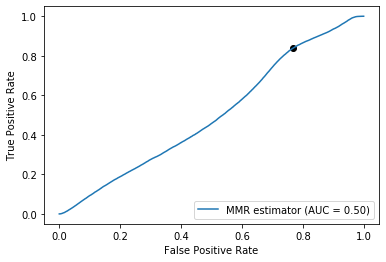

In [236]:
t = targs.cpu().numpy() #MSS is labeled as 0, MSI as 1
p = preds.float().softmax(dim=-1).cpu()[...,-1]
fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [237]:

precision, recall, thresholds = metrics.precision_recall_curve(t,p)


In [238]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] == 0.5]

array([[0.13470699, 0.55638019, 0.5       ]])

In [239]:
precision_recall_threshold[precision_recall_threshold[:,2] == best_thresh]

array([[0.15108597, 0.84064414, 0.28163972]])

auc = 0.4999333295043447


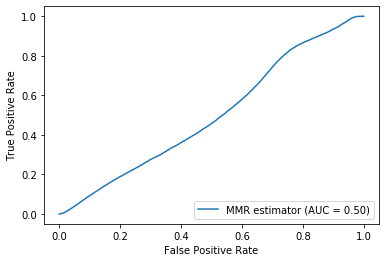

In [240]:

fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot()  
plt.show() 

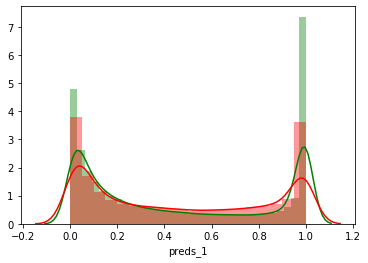

In [241]:
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs, losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [242]:
targs.cpu().numpy(), preds.float().softmax(dim=-1).cpu()

(array([0, 0, 0, ..., 0, 0, 1]),
 TensorImage([[0.3594, 0.6406],
         [0.4371, 0.5629],
         [0.4584, 0.5416],
         ...,
         [0.3419, 0.6581],
         [0.2750, 0.7250],
         [0.2984, 0.7016]]))

In [243]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs.cpu().numpy(), decoded.cpu())

array([[ 73278, 102088],
       [ 12672,  15893]])

In [244]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh
best_decoded

TensorImage([True, True, True,  ..., True, True, True])

In [245]:
skm.confusion_matrix(targs.cpu().numpy(), best_decoded)

array([[ 40449, 134917],
       [  4556,  24009]])

### Agregate prediction by patient

[0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 1] [0.55984957 0.61876529 0.28980473 0.31240296 0.27453188 0.66331422
 0.51915826 0.64832716 0.50404514 0.5370793  0.67601786 0.63622996
 0.60577914 0.58744723 0.66052896 0.67798868 0.52279212 0.29698697
 0.27939807 0.5749643  0.52306958 0.70328086 0.60059381 0.69940373
 0.61020033 0.33137709 0.27869647 0.46500158 0.56353612 0.50730489
 0.33394819 0.47966345 0.6814907  0.52121953 0.69202869 0.59675442
 0.59499775 0.44342967 0.31174046 0.47703854 0.32857288 0.5817016
 0.32503711 0.29634821 0.44900127 0.46890228 0.47776294]
auc = 0.5023809523809524, best threshold = 0.443429673047659


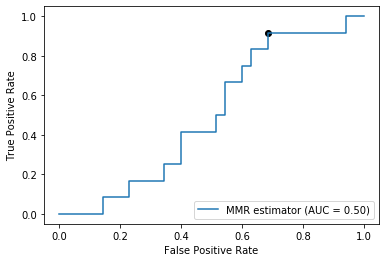

In [246]:
_d_sub.loc[_d_sub.valid == 1, 'preds'] = np.array(preds_val)

_targs = _d_sub.loc[(_d_sub.valid == 1)  ].groupby('patient_ID').label.mean().values
_preds = _d_sub.loc[(_d_sub.valid == 1)  ].groupby('patient_ID').preds.mean().values
_targs[_targs == 2.0] = 0
_targs[_targs == 1.0] = 1
_preds = _preds[_targs >= 0]

_targs = _targs[_targs >= 0]
print(_targs,_preds)

t = _targs #MSS is labeled as 0, MSI as 1
p = _preds
fpr, tpr, thresholds = skm.roc_curve(_targs,_preds)
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [247]:
_best_decoded = _preds >= best_thresh
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(_targs
                     , _best_decoded)

array([[11, 24],
       [ 1, 11]])

## Activation Maps

In [ ]:
select = _d_sub.loc[(_d_sub.label == 1) & (_d_sub.clas_idx == 'TUM')  & (_d_sub.valid == 1)].iloc[1]

In [ ]:
x = get_x(select)
img_label = f'{select.tif_fn}_{select.spot_coord}_{select.spot_ID}_Label_{labels[int(select.label)]}.png'
print(img_label)

In [ ]:
y = learn.dls.test_dl([select])
learn.get_preds(dl=y)

In [ ]:
xb = learn.xb

In [ ]:
show_image(xb[0].squeeze(0))

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o): self.stored = o[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        

In [ ]:
with Hook(learn.model.feature_extractor) as hook:
    with torch.no_grad(): output = learn.model.eval()(xb[0])
    act = hook.stored

In [ ]:
act.shape

In [ ]:
learn.model.msi_classifier[-1].weight.shape

In [ ]:
output = output[0]

In [ ]:
F.softmax(output, dim=-1)

In [ ]:
can_map = torch.einsum('ck,kij->cij', learn.model.msi_classifier[-1].weight,act)

In [ ]:
can_map.shape

In [ ]:

_,ax = plt.subplots()
#x_dec.show(ctx=ax)

ax.imshow(can_map[1].detach().cpu(), alpha=0.6, extent=(0,300,300,0),
         interpolation = 'bilinear', cmap = 'magma');

print(select)
show_image(x)


# SHAP

In [ ]:
import shap

In [ ]:
b=learn.dls[1].one_batch()

In [ ]:
b[0].shape

In [ ]:
learn.model.force_msi = True
out = learn.model.eval()(b[0][40:45])
out


In [ ]:
preds = Tensor(out.cpu().detach().numpy())
preds = preds.float().softmax(dim=-1).cpu()
preds

In [ ]:
xb=Tensor(b[0].cpu()).cuda()

In [ ]:
learn.model.force_msi = True
e=shap.DeepExplainer(learn.model,xb[:100])

In [ ]:
yb= b[1].cpu()
test_labels = np.array(yb[40:45])
test_labels

In [ ]:
test_images=xb[40:45]
shap_values = e.shap_values(test_images)

In [ ]:
denorm = lambda t:Normalize.from_stats(*tissue_stats).decodes(TensorImage(t))

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(denorm(s), 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(denorm(test_images).cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

In [ ]:
shap.image_plot(shap_numpy, test_numpy, labels= preds)